# MaldiAMRKit - Peak Detection

This notebook covers peak detection methods including local maxima and persistent homology.

## Import Libraries

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from maldiamrkit import MaldiSet
from maldiamrkit.detection import MaldiPeakDetector

## Load Dataset

In [2]:
data = MaldiSet.from_directory(
    "../data/",
    "../data/metadata/metadata.csv",
    aggregate_by=dict(antibiotics="Drug"),
)
X = data.X
y = data.y["Drug"].map({"S": 0, "I": 1, "R": 1})

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (29, 6000)
Labels shape: (29,)


## Peak Detection with Local Maxima

The `MaldiPeakDetector` uses local maxima detection by default. It's fast and works well for most cases.

In [3]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline(
    [
        ("peaks", MaldiPeakDetector(binary=False, prominence=1e-8)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression()),
    ]
)

scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
print(f"CV ROC AUC: {scores.mean():.3f} +/- {scores.std():.3f}")

CV ROC AUC: 0.417 +/- 0.260


## Peak Detection with Persistent Homology

Persistent homology (`method="ph"`) is a topological approach that can better handle noise. It's slower but often more robust.

**Note:** Requires the `gudhi` package.

In [4]:
peak_detector = MaldiPeakDetector(
    method="ph",
    binary=False,
    persistence_threshold=5e-4,
)

# Fit on a subset and get statistics
peak_detector.fit(X.iloc[:5])
peak_detector.get_peak_statistics(X.iloc[:5])

,n_peaks,mean_intensity,max_intensity
10s,40,0.001594,0.005164
11s,43,0.001695,0.006086
12s,48,0.001844,0.007017
13s,56,0.001946,0.007615
14s,49,0.001784,0.005047


### Visualize Detected Peaks

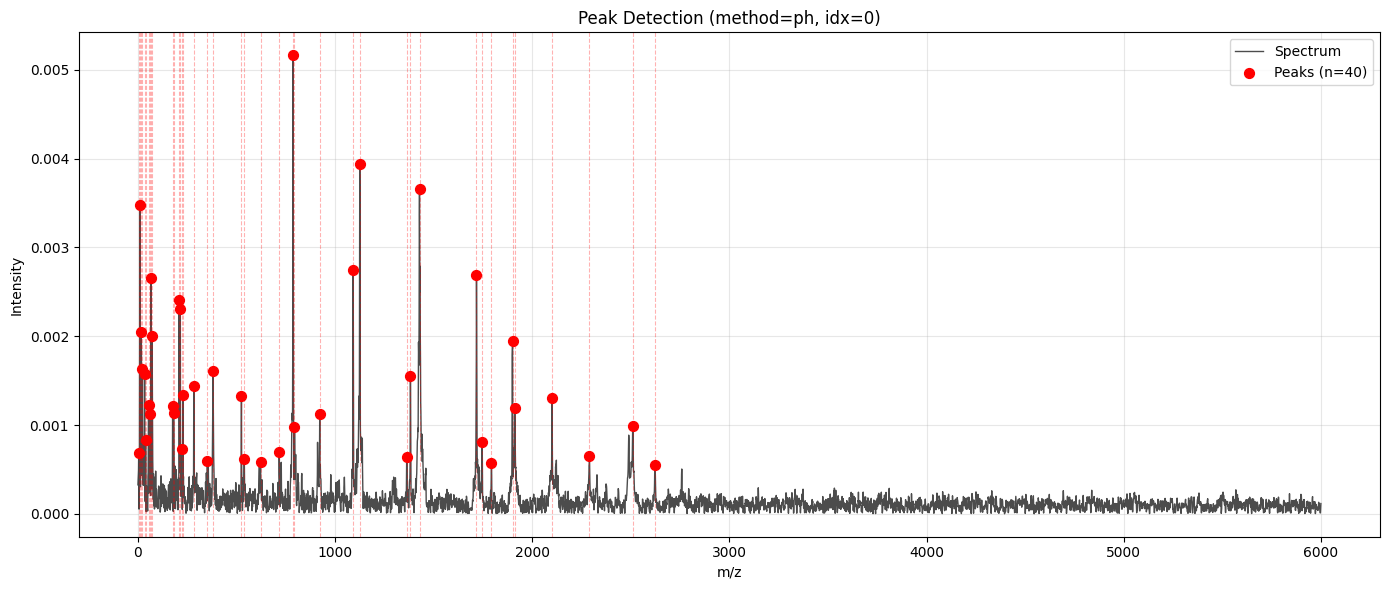

In [5]:
_ = peak_detector.plot_peaks(X.iloc[0])

## Binary vs Intensity Mode

The `binary` parameter controls whether peak positions are returned as binary (0/1) or preserve original intensities.

In [6]:
# Binary mode - peaks are marked as 1, non-peaks as 0
detector_binary = MaldiPeakDetector(binary=True, prominence=1e-4)
peaks_binary = detector_binary.fit_transform(X.iloc[:1])
print(f"Binary mode unique values: {peaks_binary.values.flatten()[:20]}")

# Intensity mode - preserves original intensities at peak positions
detector_intensity = MaldiPeakDetector(binary=False, prominence=1e-4)
peaks_intensity = detector_intensity.fit_transform(X.iloc[:1])
print(
    f"Intensity mode - non-zero values: {peaks_intensity.values[peaks_intensity.values > 0][:10]}"
)

Binary mode unique values: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
Intensity mode - non-zero values: [0.0006844  0.00347906 0.00088132 0.00204877 0.00098946 0.00162945
 0.00086379 0.00157396 0.00082802 0.00031478]


## Parallelization

Use `n_jobs` parameter to enable parallel processing for faster computation on large datasets.

In [7]:
# Sequential processing
detector_seq = MaldiPeakDetector(prominence=1e-4, n_jobs=1)

# Parallel processing (use all cores)
detector_par = MaldiPeakDetector(prominence=1e-4, n_jobs=-1)

# Both produce the same results
result = detector_par.fit_transform(X)
print(f"Processed {len(X)} spectra")

Processed 29 spectra
